# NISP-S red grism

**Author:** Yannick Copin <y.copin@ipnl.in2p3.fr>

We apply the naive spectrograph model (i.e. including a grism in a collimated beam) to the NISP-S instrument with red grism.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import mpld3
mpld3.enable_notebook()
import numpy as N
import spectrogrism as S
S.__version__

/data/ycopin/Softs/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/data/ycopin/Softs/local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/data/ycopin/Softs/local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


'0.4'

In [3]:
import nisp

## Zemax simulations

Load the Zemax simulations:

In [4]:
simulations = S.Configuration([
        ("name", "Zemax"),
        (1, "Zemax/run_190315.dat"),           # 1st-order simulation
        (0, "Zemax/run_011115_conf2_o0.dat"),  # 0th-order simulation
        (2, "Zemax/run_161115_conf2_o2.dat"),  # 2nd-order simulation
    ])
print(simulations)

----------------------- Configuration 'Zemax' ------------------------
  name                : Zemax
  1                   : Zemax/run_190315.dat
  0                   : Zemax/run_011115_conf2_o0.dat
  2                   : Zemax/run_161115_conf2_o2.dat


In [5]:
zmx = nisp.Zemax(simulations)
print(zmx)

Simulations: Zemax
  Order #1: Zemax/run_190315.dat
  Order #0: Zemax/run_011115_conf2_o0.dat
  Order #2: Zemax/run_161115_conf2_o2.dat
  Wavelengths: 13 steps from 1.20 to 1.80 µm
  Coords: 17 × 17 sources


nisp.py:162: UserWarning: Setting approximately null xindeg to 0
  warnings.warn("Setting approximately null xindeg to 0")
nisp.py:166: UserWarning: Offsetting Yin by -0.85 deg
  warnings.warn("Offsetting Yin by -0.85 deg")
nisp.py:170: UserWarning: Discarding wavelengths > 1.81 µm
  warnings.warn("Discarding wavelengths > 1.81 µm")


Input sources:

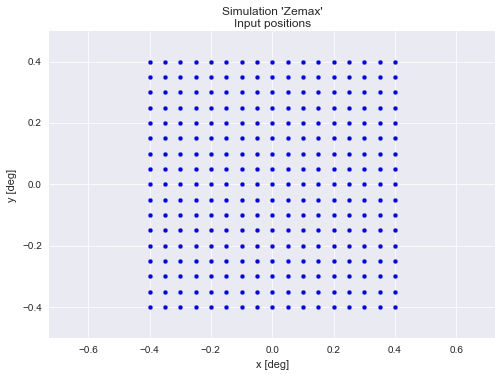

In [6]:
ax = zmx.plot_input()

## Optical modeling

We use here the standard/naive model: telescope + collimator + grism + camera + detector.

In [7]:
# Optical modeling
optcfg = S.OptConfig(nisp.NISP_R)  # Optical configuration (default NISP)
print(optcfg)

------------------- Optical configuration 'NISP-R' -------------------
  name                : NISP-R
  wave_ref            : 1.5e-06
  wave_range          : [1.25e-06, 1.85e-06]
  telescope_flength   : 25.2
  grism_on            : True
  grism_dispersion    : 9.8
  grism_prism_material: FS
  grism_grating_material: FS
  grism_prism_angle   : 0.0471238898038
  grism_grating_rho   : 13.1
  grism_grating_blaze : 0.0453785605519
  detector_pxsize     : 1.8e-05
  collimator_flength  : 1.946
  collimator_distortion: 0.0028
  camera_flength      : 0.957
  camera_distortion   : 0.0296
  detector_dx         : 0.0007
  detector_dy         : -0.0042


In [8]:
simcfg = zmx.get_simcfg()     # Simulation configuration
print(simcfg)

------------------ Simulation configuration 'Zemax' ------------------
  name                : Zemax
  wave_npx            : 13
  wave_range          : [1.1999999999999999e-06, 1.7999999999999999e-06]
  orders              : [1, 0, 2]
  input_coords        : [[-0.00698132 -0.00698132]
 [-0.00698132 -0.00610865]
 [-0.00698132 -0.00523599]
 ..., 
 [ 0.00698132  0.00523599]
 [ 0.00698132  0.00610865]
 [ 0.00698132  0.00698132]]


In [9]:
spectro = S.Spectrograph(optcfg,
                         grism_on=optcfg.get('grism_on', True),
                         telescope=S.Telescope(optcfg))
print(spectro)

----------------------- Spectrograph -----------------------
Telescope:  f=25.2 m, e=+0.000
Collimator: f=1.9 m, e=+0.003
Grism:
  Prism [FS]: A=2.70°, tilts=+0',+0',+0'
  Grating [FS]: rho=13.1 g/mm, blaze=2.60°
  1st-order null-deviation wavelength: 1.59 µm
Camera: f=1.0 m, e=+0.030
Detector: pxsize=18 µm
  offset=(+0.700, -4.200) mm, angle=0.0 deg
Spectrograph magnification: 0.492
Central dispersion: 13.73 AA/px at 1.50 µm


In [10]:
try:
    spectro.test(simcfg, verbose=False)
except AssertionError as err:
    print "ERROR Spectrograph test:", err
else:
    print("Spectrograph test: OK")

Spectrograph test: OK


In [11]:
model = spectro.model(simcfg, orders=zmx.orders)
# Compute RMS on 1st-order positions
rms = zmx.positions.compute_rms(model, order=1)
print("1st-order RMS = {:.4f} mm = {:.2f} px".format(rms / 1e-3, rms / spectro.detector.pxsize))
rms = zmx.positions.compute_rms(model, order=0)
print("0th-order RMS = {:.4f} mm = {:.2f} px".format(rms / 1e-3, rms / spectro.detector.pxsize))
rms = zmx.positions.compute_rms(model, order=2)
print("2nd-order RMS = {:.4f} mm = {:.2f} px".format(rms / 1e-3, rms / spectro.detector.pxsize))

1st-order RMS = 0.1844 mm = 10.25 px
0th-order RMS = 0.3509 mm = 19.50 px
2nd-order RMS = 0.4524 mm = 25.13 px


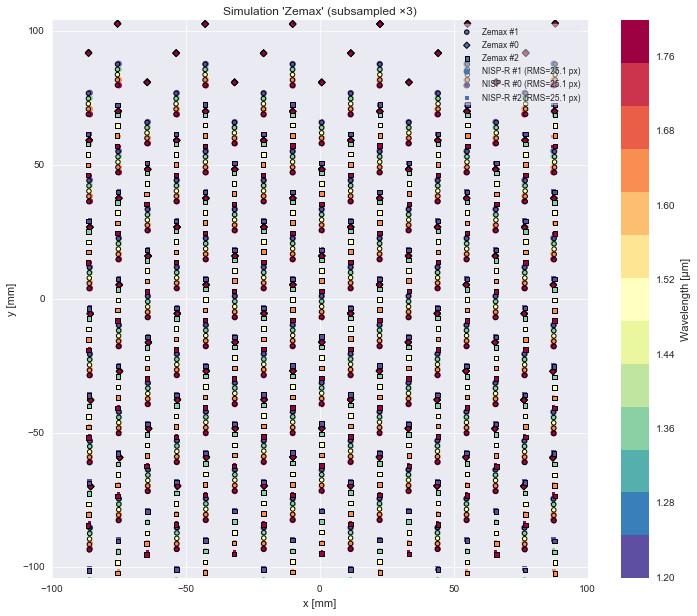

In [12]:
subsampling = 3             # Subsample output plot
kwargs = dict(s=20, edgecolor='k', linewidths=1)  # Outlined symbols
ax = zmx.plot_output(orders=zmx.orders, subsampling=subsampling, **kwargs)

kwargs = {}                      # Default
model.plot(ax=ax, zorder=0,  # Draw below Zemax
           orders=(1,),
           subsampling=subsampling,
           label="{} #1 (RMS={:.1f} px)".format(model.name, rms / spectro.detector.pxsize),
           **kwargs)
model.plot(ax=ax, zorder=0,  # Draw below Zemax
           orders=(0,), blaze=True,
           subsampling=subsampling,
           label="{} #0 (RMS={:.1f} px)".format(model.name, rms / spectro.detector.pxsize),
           **kwargs)
model.plot(ax=ax, zorder=0,  # Draw below Zemax
           orders=(2,), blaze=True,
           subsampling=subsampling,
           label="{} #2 (RMS={:.1f} px)".format(model.name, rms / spectro.detector.pxsize),
           **kwargs)

ax.axis([-100, +100, -100, +100])               # [mm]
ax.set_aspect('equal', adjustable='datalim')
ax.legend(fontsize='small', frameon=True, framealpha=0.5, title='')
ax.figure.set_size_inches(12, 10)

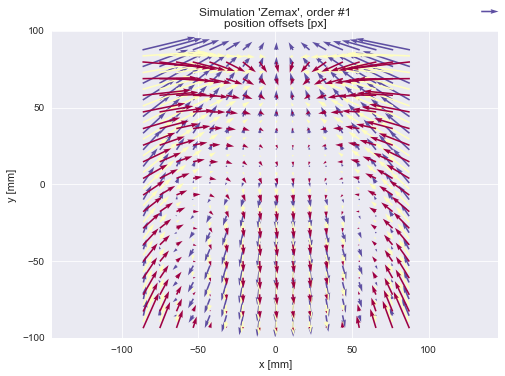

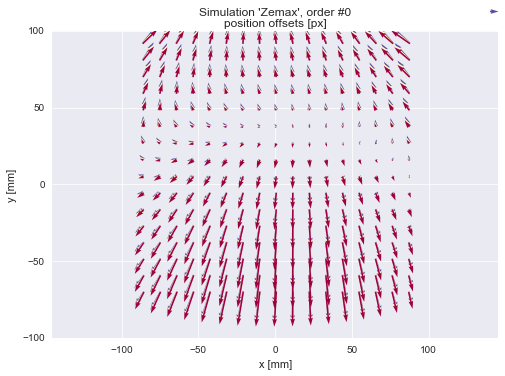

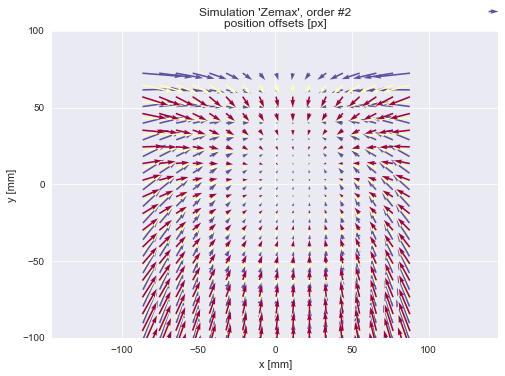

In [13]:
# Position offset quiver plots
for order in zmx.orders:
    ax = zmx.plot_offsets(model, order=order)